In [18]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

import random
from os import cpu_count

ROOT = '/kaggle/input/hc18-grand-challenge/'

In [19]:
train_df = pd.read_csv(ROOT + 'training_set_pixel_size_and_HC.csv')
test_df = pd.read_csv(ROOT + 'test_set_pixel_size.csv')

In [20]:
def imread(filename, anno=False):
    if anno:
        name, ext = filename.split('.')
        filename = f'{name}_Annotation.{ext}'

    path = ROOT + 'training_set/' + filename
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    return img

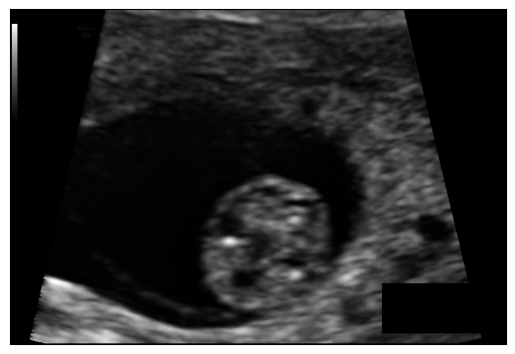

In [21]:
img = imread('000_HC.png')
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('raw')

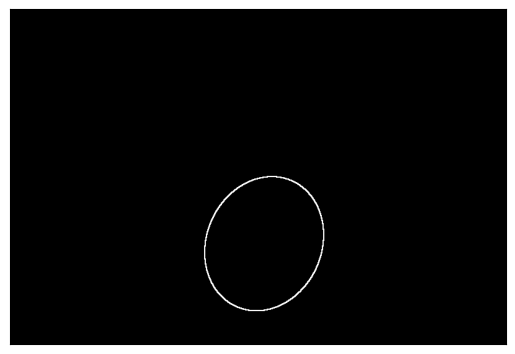

In [22]:
img = imread('000_HC_Annotation.png')
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('anno')

In [23]:
def find_contour(img):
    cts, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    return cts[0]

def draw_contour(img, ct, fill:bool):
    thickness = -1 if fill else 1
    bg = np.zeros_like(img)
    cv.drawContours(bg, [ct], 0, 255, thickness)
    return bg

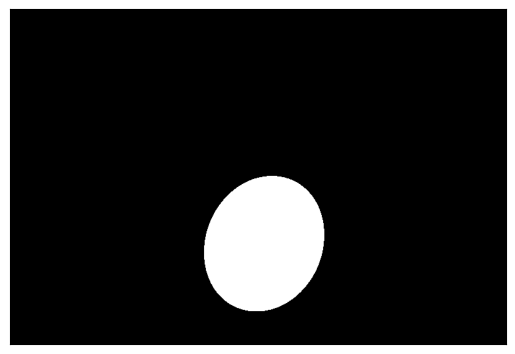

In [24]:
img = imread('000_HC_Annotation.png')
ct = find_contour(img)
x = draw_contour(img, ct, True)
plt.imshow(x, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('fill')

In [25]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, 2, 2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2], dim=1)
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.conv = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.out = nn.Conv2d(64, n_classes, 1)
        
    # NOTE: resize so that height and width divided by 8
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        x = self.up1(x4, x3)
        del x4, x3
        x = self.up2(x, x2)
        del x2
        x = self.up3(x, x1)
        del x1
        
        return self.out(x)

In [26]:
def fill(img):
    ct = find_contour(img)
    return draw_contour(img, ct, True)

def transform(img, flip:bool):
    img = cv.resize(img, (200, 128))
    img = torch.Tensor(img).float().unsqueeze(0)
    img = v2.RandomHorizontalFlip(flip)(img)
    return img
    
class UltraSound:
    def __init__(self, df, flip):
        self.fnames = df['filename'].values
        self.flip = flip
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        flip = random.choice([True, False]) if self.flip else False
        
        raw = transform(imread(fname), flip)
        anno = transform(fill(imread(fname, True)), flip)
        
        return raw, anno//255

In [27]:
val = train_df.sample(frac=0.1, random_state=42)
train = train_df.drop(val.index)

val = UltraSound(val, False)
train = UltraSound(train, True)

NUM_CPU = cpu_count()
val_loader = DataLoader(val, batch_size=16, shuffle=False, num_workers=NUM_CPU)
train_loader = DataLoader(train, batch_size=16, shuffle=True, num_workers=NUM_CPU)

torch.Size([16, 1, 128, 200])
torch.Size([16, 1, 128, 200])


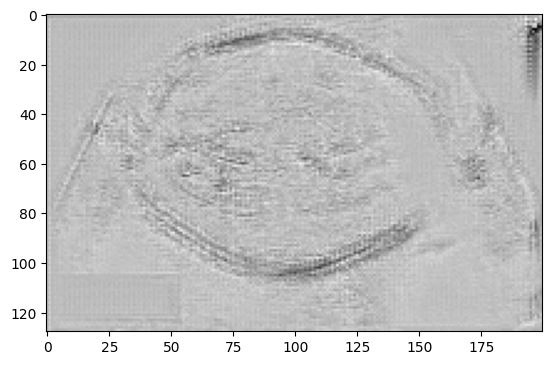

In [28]:
raw, anno = next(iter(train_loader))
print(raw.shape)
model = UNet(1,1).to('cuda')
raw = raw.to('cuda')
with torch.no_grad():
    out = model(raw)

out = out.detach().cpu()
print(out.shape)
plt.imshow(out[0,0], cmap='gray')

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(1,1).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optim_fn = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 50
best_loss = 1e5
for epoch in range(1, n_epochs+1):
    model.train()
    losses = []
    for raw, anno in tqdm(train_loader, desc=f'Epoch {epoch}'):
        raw = raw.to(device)
        anno = anno.to(device)
        
        pred = model(raw)
        loss = criterion(pred, anno)
        losses.append(loss)
        
        loss.backward()
        optim_fn.step()
        
    mean_loss = sum(losses)/len(losses)
    print(f'Train loss: {mean_loss:.5f}')

    # EVAL
    model.eval()
    losses = []
    for raw, anno in tqdm(val_loader, desc=f'Validate'):
        raw = raw.to(device)
        anno = anno.to(device)
        
        with torch.no_grad():
            pred = model(raw)
            loss = criterion(pred, anno)
            losses.append(loss)
    
    mean_loss = sum(losses)/len(losses)
    print(f'Val loss: {mean_loss:.5f}')
    if mean_loss < best_loss:
        torch.save(model.state_dict(), 'best_model.pt')

Epoch 1: 100%|██████████| 57/57 [00:08<00:00,  6.45it/s]


Train loss: 0.46256


Validate: 100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


Val loss: 8.64045


Epoch 2: 100%|██████████| 57/57 [00:08<00:00,  6.95it/s]


Train loss: 0.37361


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.64it/s]


Val loss: 0.86198


Epoch 3: 100%|██████████| 57/57 [00:08<00:00,  6.98it/s]


Train loss: 0.35285


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.14it/s]


Val loss: 0.37196


Epoch 4: 100%|██████████| 57/57 [00:08<00:00,  6.99it/s]


Train loss: 0.30958


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


Val loss: 0.37279


Epoch 5: 100%|██████████| 57/57 [00:08<00:00,  6.99it/s]


Train loss: 0.27225


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.36it/s]


Val loss: 0.25464


Epoch 6: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.24813


Validate: 100%|██████████| 7/7 [00:00<00:00, 10.86it/s]


Val loss: 0.23142


Epoch 7: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.22156


Validate: 100%|██████████| 7/7 [00:00<00:00,  9.71it/s]


Val loss: 0.23407


Epoch 8: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.21677


Validate: 100%|██████████| 7/7 [00:00<00:00,  9.53it/s]


Val loss: 0.28743


Epoch 9: 100%|██████████| 57/57 [00:08<00:00,  6.90it/s]


Train loss: 0.21054


Validate: 100%|██████████| 7/7 [00:00<00:00, 10.38it/s]


Val loss: 0.21200


Epoch 10: 100%|██████████| 57/57 [00:08<00:00,  6.92it/s]


Train loss: 0.19063


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.40it/s]


Val loss: 0.22353


Epoch 11: 100%|██████████| 57/57 [00:08<00:00,  6.98it/s]


Train loss: 0.20210


Validate: 100%|██████████| 7/7 [00:00<00:00,  9.57it/s]


Val loss: 0.21480


Epoch 12: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.18525


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]


Val loss: 0.22890


Epoch 13: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.19124


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.33it/s]


Val loss: 0.21524


Epoch 14: 100%|██████████| 57/57 [00:08<00:00,  6.99it/s]


Train loss: 0.17211


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.28it/s]


Val loss: 0.17653


Epoch 15: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.17029


Validate: 100%|██████████| 7/7 [00:00<00:00, 10.90it/s]


Val loss: 0.19656


Epoch 16: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.17537


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.47it/s]


Val loss: 0.20400


Epoch 17: 100%|██████████| 57/57 [00:08<00:00,  6.95it/s]


Train loss: 0.15988


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.52it/s]


Val loss: 0.18707


Epoch 18: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.16333


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.28it/s]


Val loss: 0.17972


Epoch 19: 100%|██████████| 57/57 [00:08<00:00,  6.90it/s]


Train loss: 0.16285


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.35it/s]


Val loss: 0.16673


Epoch 20: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.15658


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.39it/s]


Val loss: 0.16774


Epoch 21: 100%|██████████| 57/57 [00:08<00:00,  6.99it/s]


Train loss: 0.15431


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.13it/s]


Val loss: 0.19116


Epoch 22: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.16019


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


Val loss: 0.18291


Epoch 23: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.14884


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.01it/s]


Val loss: 0.14801


Epoch 24: 100%|██████████| 57/57 [00:08<00:00,  6.98it/s]


Train loss: 0.14699


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.00it/s]


Val loss: 0.14723


Epoch 25: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.15545


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.52it/s]


Val loss: 0.15072


Epoch 26: 100%|██████████| 57/57 [00:08<00:00,  6.99it/s]


Train loss: 0.15245


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.45it/s]


Val loss: 0.15140


Epoch 27: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.14685


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.56it/s]


Val loss: 0.15173


Epoch 28: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.14614


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.03it/s]


Val loss: 0.16110


Epoch 29: 100%|██████████| 57/57 [00:08<00:00,  6.97it/s]


Train loss: 0.14514


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.52it/s]


Val loss: 0.16018


Epoch 30: 100%|██████████| 57/57 [00:08<00:00,  6.97it/s]


Train loss: 0.14631


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.16it/s]


Val loss: 0.15474


Epoch 31: 100%|██████████| 57/57 [00:08<00:00,  6.98it/s]


Train loss: 0.14527


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.12it/s]


Val loss: 0.15329


Epoch 32: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.14410


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.29it/s]


Val loss: 0.14456


Epoch 33: 100%|██████████| 57/57 [00:08<00:00,  7.02it/s]


Train loss: 0.14086


Validate: 100%|██████████| 7/7 [00:00<00:00, 10.85it/s]


Val loss: 0.13720


Epoch 34: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.13304


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.58it/s]


Val loss: 0.13264


Epoch 35: 100%|██████████| 57/57 [00:08<00:00,  6.99it/s]


Train loss: 0.13318


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.23it/s]


Val loss: 0.13765


Epoch 36: 100%|██████████| 57/57 [00:08<00:00,  6.98it/s]


Train loss: 0.13599


Validate: 100%|██████████| 7/7 [00:00<00:00,  9.55it/s]


Val loss: 0.14092


Epoch 37: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.14048


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.10it/s]


Val loss: 0.14231


Epoch 38: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.13877


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.38it/s]


Val loss: 0.13978


Epoch 39: 100%|██████████| 57/57 [00:08<00:00,  6.98it/s]


Train loss: 0.13352


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.51it/s]


Val loss: 0.13321


Epoch 40: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.13179


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.39it/s]


Val loss: 0.13243


Epoch 41: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.13253


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.34it/s]


Val loss: 0.13123


Epoch 42: 100%|██████████| 57/57 [00:08<00:00,  6.99it/s]


Train loss: 0.13383


Validate: 100%|██████████| 7/7 [00:00<00:00, 10.66it/s]


Val loss: 0.13363


Epoch 43: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.13182


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.44it/s]


Val loss: 0.13340


Epoch 44: 100%|██████████| 57/57 [00:08<00:00,  6.90it/s]


Train loss: 0.12674


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


Val loss: 0.13569


Epoch 45: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.12895


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.15it/s]


Val loss: 0.13559


Epoch 46: 100%|██████████| 57/57 [00:08<00:00,  7.01it/s]


Train loss: 0.12990


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.43it/s]


Val loss: 0.12977


Epoch 47: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.13167


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.47it/s]


Val loss: 0.13315


Epoch 48: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.12499


Validate: 100%|██████████| 7/7 [00:00<00:00, 10.93it/s]


Val loss: 0.12238


Epoch 49: 100%|██████████| 57/57 [00:08<00:00,  6.99it/s]


Train loss: 0.12412


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.31it/s]


Val loss: 0.11919


Epoch 50: 100%|██████████| 57/57 [00:08<00:00,  7.00it/s]


Train loss: 0.12475


Validate: 100%|██████████| 7/7 [00:00<00:00, 11.70it/s]


Val loss: 0.12045


In [32]:
errors = []
for filename, ps, hc in train_df.values:
    name, ext = filename.split('.')
    filename = f'{name}_Annotation.{ext}'
    img = imread(filename)
    ct = find_contour(img)
    L = cv.arcLength(ct, True)
    errors.append(L * ps - hc)

errors = np.array(errors)

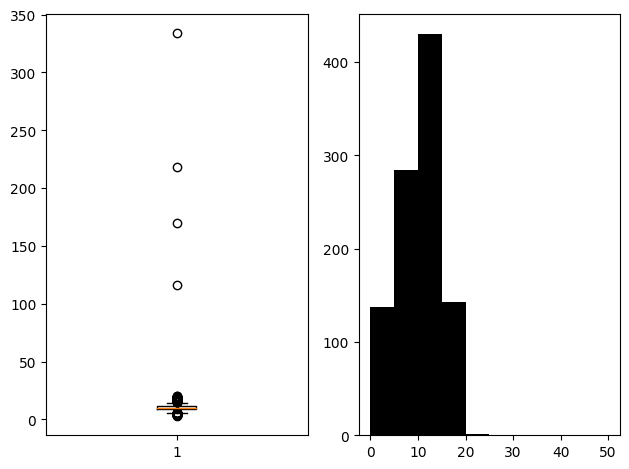

In [33]:
plt.subplot(121)
plt.boxplot(errors)
plt.subplot(122)
plt.hist(errors, range=(0,50), color='k')
plt.tight_layout()
plt.savefig('error')

torch.Size([16, 1, 128, 200])
torch.Size([16, 1, 128, 200])


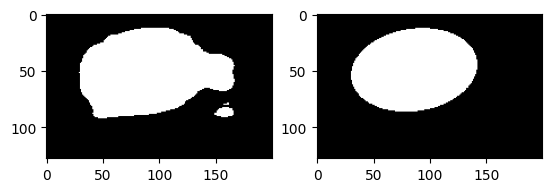

In [36]:
model = UNet(1,1).to(device)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

raw, anno = next(iter(val_loader))
print(raw.shape)
raw = raw.to('cuda')
with torch.no_grad():
    out = model(raw)

out = out.detach().cpu()
out = torch.sigmoid(out) > 0.5
print(out.shape)

plt.subplot(121)
plt.imshow(out[0,0], cmap='gray')
plt.subplot(122)
plt.imshow(anno[0,0], cmap='gray')

In [67]:
ious = []
for raw, anno in tqdm(val_loader, desc=f'Validate'):
    raw = raw.to(device)
    with torch.no_grad():
        pred = model(raw)

    pred = pred.detach().cpu()
    pred = torch.sigmoid(pred) > 0.5

    anno = anno.detach().cpu().bool()

    I = (pred & anno).sum(dim=[2,3])
    U = (pred | anno).sum(dim=[2,3])
    IOU = (I/U).squeeze().tolist()
    ious += IOU
    
print(f'Metric: {sum(ious)/len(ious)}')

Validate: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s]

Metric: 0.8211649003624916
